In [1]:
import os
import sys
sys.path.append('../pyWholeBrain')
import numpy as np
import colorsys
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import scipy
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

from skimage.measure import label, regionprops
from scipy.ndimage.filters import gaussian_filter, convolve
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing

from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from sklearn.model_selection import train_test_split

from hdf5manager import hdf5manager as h5
import wholeBrain as wb
import sklearn
from sklearn.cluster import OPTICS
import math

Error importing slackNotify.py
	 ERROR :  No module named 'slacker'


In [2]:
file_dir = '/Users/jcrndm/Documents/'

file = '170721_07_c1_gridOpticFlow_metrics.csv'

data_big = pd.DataFrame.from_csv(file_dir + file)
#print(data_big.head())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


In [3]:
non_nan_brain = []
non_nan_angs = []

for i in range(len(data_big["brain.data"])):
    if (math.isnan(data_big["brain.data"][i])):
        non_nan_brain.append(0)
    else:
        non_nan_brain.append(data_big["brain.data"][i])
        
for i in range(len(data_big["angs.stdev"])):
    if (math.isnan(data_big["angs.stdev"][i])):
        non_nan_angs.append(0)
    else:
        non_nan_angs.append(data_big["angs.stdev"][i])

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_scaled = scaler.fit_transform(data_big)
x_scaled.shape
columns = data_big.columns.tolist()
for i, col in enumerate(columns):
    data_big[col] = x_scaled[:,i]
    
# Classification
indices_big = np.zeros(len(data_big))
indices_big[2445 : 3388] = 1
indices_big[5166 : 5569] = 1
indices_big[8617 : 9298] = 1
indices_big[11751 : 12024] = 1
indices_big[15367 : 15889] = 1
indices_big[17619 : 17964] = 1
data_big['classification'] = indices_big

In [11]:
from imblearn.over_sampling import SMOTE

y = data_big.loc[:,'classification'].values

# y = np.squeeze(pd.DataFrame(np.ndarray.astype(y, int), columns=['signal']))
X = data_big.loc[:, data_big.columns != 'classification'].fillna(value=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

#augment your data
os = SMOTE(random_state=42)

columns = X_train.columns
os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data = os_data_y, columns =['classification'])

print('Length of data augmentation:', len(os_data_X))
print('Number of addition singal points: {0} \t\tProportion: {1}'.format(len(os_data_y[os_data_y['classification'] == 1]), len(os_data_y[os_data_y['classification'] == 1])/len(os_data_X)))
print('Number of addition non-singal points: {0} \tProportion: {1}'.format(len(os_data_y[os_data_y['classification'] == 0]), len(os_data_y[os_data_y['classification'] == 0])/len(os_data_X)))




Length of data augmentation: 20846
Number of addition singal points: 10423 		Proportion: 0.5
Number of addition non-singal points: 10423 	Proportion: 0.5


In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs')

rfe = RFE(logreg, 20) #increase paramater for numnber of iterations?
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
data_final_vars = os_data_X.columns.tolist()

print('Support\tRanking\tVariable')
for i, var in enumerate(data_final_vars):
    print(rfe.support_[i], '\t',rfe.ranking_[i],'\t', var)

new_vars = X.columns.values[rfe.ranking_ == 1].tolist()
# new_vars.append('class')
new_vars.append('classification')

print(new_vars)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Support	Ranking	Variable
True 	 1 	 angs.stdev
False 	 8 	 angs.mean
True 	 1 	 mov.mean
True 	 1 	 mov.std
False 	 7 	 mov.mode
True 	 1 	 mov.range
True 	 1 	 mov.eventrest
False 	 3 	 mov.maxeventval
True 	 1 	 mov.surfarea
False 	 5 	 mov.totalmag
False 	 10 	 mov.firstder
False 	 12 	 mov.secder
True 	 1 	 mov.stdx
False 	 11 	 mov.stdy
False 	 9 	 mov.diffxystd
False 	 2 	 mov.diffmaxevents
False 	 13 	 mov.percent
True 	 1 	 mov.percenterror
True 	 1 	 mov.timetoevent
True 	 1 	 mov.timefromevent
True 	 1 	 mov.numlocmax
True 	 1 	 mov.mag_per_event
True 	 1 	 mov.duration
True 	 1 	 mov.btwnrest
True 	 1 	 brain.data
True 	 1 	 brain.eventrest
True 	 1 	 brain.rangemaxmin
True 	 1 	 brain.firstder
True 	 1 	 brain.secondder
True 	 1 	 diff.brainmov
False 	 6 	 diff.brainmovfirstder
False 	 4 	 diff.brainmovsecder
['angs.stdev', 'mov.mean', 'mov.std', 'mov.range', 'mov.eventrest', 'mov.surfarea', 'mov.stdx', 'mov.percenterror', 'mov.timetoevent', 'mov.timefromevent', 'mov.numloc

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [59]:
def downsize(data, ds):
    width = (len(data)/ds)
    preferred_length = ds * np.ceil(len(data)/ds)
    buff_size = int(preferred_length) - len(data)
    data = np.concatenate((data, np.ones(buff_size) * np.nan), axis = 0)
    data_new = data.reshape(int(len(data)/ds), ds)
    new = []
    for i in data_new:
        new.append(np.nansum(i))
    return new

def reshape_all(data_big):
    reshaped_data = pd.DataFrame()
    for i in data_big:
        temp = downsize(data_big[i], 30)
        reshaped_data[i] = temp
    return reshaped_data

reduce = reshape_all(data_big)

In [ ]:
# data_copy = data_big[new_vars]

# # Both temporal and spatial metrics visualize  
# sns.pairplot(data_copy, 
#              diag_kind="kde", 
#              markers=["o", "s"], 
#              hue_order = [0, 1], hue='classification')

# # plt.savefig(file_dir + 'metrics_pairplot.png')
# # plt.show()

In [162]:
# new_new_vars = ['angs.stdev', 'mov.duration', 'mov.btwnrest', 'brain.data']
# new_new_vars = ['angs.stdev', 'mov.duration', 'mov.btwnrest', 'brain.data', 'mov.timefromevent']
new_new_vars = ['mov.surfarea', 'mov.stdx','brain.eventrest', 'brain.data', 'mov.diffmaxevents']
# new_new_vars = ['mov.timetoevent', 'mov.timefromevent', 'brain.data', 'brain.eventrest', 'brain.rangemaxmin']

In [163]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, 
            perplexity=5, # between 5 and 50 only 
#             learning_rate = 300,
            random_state=42)
X_reduced_tsne = tsne.fit_transform(reduce[new_new_vars].fillna(value=0).values)

In [164]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(reduce[new_new_vars].fillna(value=0).values)

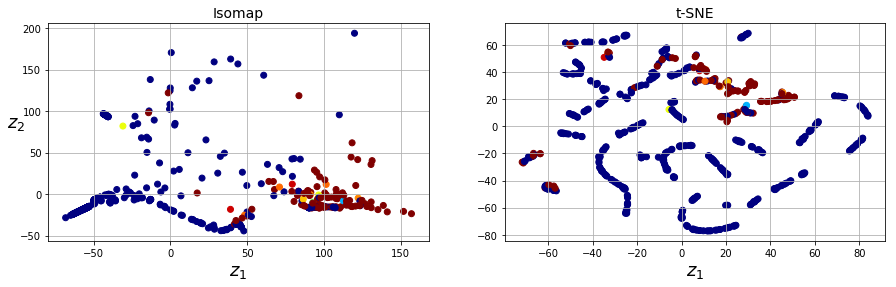

In [165]:
titles = ["Isomap", "t-SNE"]

plt.figure(figsize=(15,4))

for subplot, title, X_reduced in zip((121, 122), titles,
                                     (X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=reduce['classification'], cmap=plt.cm.jet)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 121:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

# save_fig("other_dim_reduction_plot")
plt.show()

In [167]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

kmeans = KMeans(n_clusters= 2, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X_reduced_isomap)
prediction = kmeans.predict(X_reduced_isomap)

colors = ["blue", "red", "orange", "yellow", "green", "purple"]

plt.figure(figsize = (10,8))

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [168]:
# def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
#     labels = kmeans.fit_predict(X)
#     # plot the input data
#     ax = ax or plt.gca()
#     ax.axis('equal')
#     ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

#     # plot the representation of the KMeans model
#     centers = kmeans.cluster_centers_
#     radii = [cdist(X[labels == i], [center]).max()
#              for i, center in enumerate(centers)]
#     for c, r in zip(centers, radii):
#         ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
#     return labels

# indices_isomap = kmeans.fit_predict(X_reduced_tsne)
# plot_kmeans(kmeans, X_reduced_tsne)


array([2, 2, 2, 2, 0, 2, 2, 0, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3,
       2, 2, 2, 0, 3, 3, 2, 1, 0, 1, 0, 1, 0, 0, 2, 3, 3, 2, 2, 2, 2, 3,
       3, 3, 2, 3, 3, 2, 2, 0, 0, 2, 2, 3, 3, 2, 0, 2, 2, 3, 3, 2, 0, 0,
       0, 0, 1, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 3, 1, 3,
       3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 1, 0, 1, 1, 2, 3,
       2, 2, 2, 1, 1, 0, 0, 3, 3, 0, 3, 3, 2, 1, 2, 2, 2, 3, 3, 2, 1, 1,
       2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 1, 1, 2, 3, 1, 1, 2,
       3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 0,
       2, 1, 1, 1, 2, 3, 2, 1, 1, 0, 2, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1,
       1, 3, 3, 2, 1, 1, 2, 3, 3, 3, 2, 1, 1, 2, 2, 0, 2, 3, 2, 2, 2, 0,
       2, 3, 3, 3, 3, 2, 1, 1, 2, 2, 3, 3, 0, 2, 1, 1, 2, 3, 3, 3, 3, 3,
       0, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 1, 2, 3, 3, 3, 3, 3, 2, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,

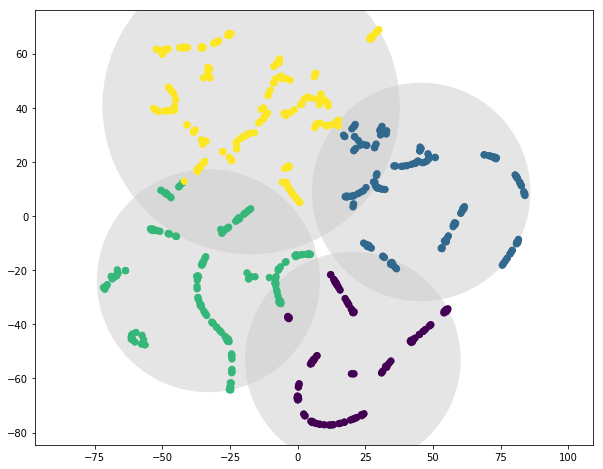

In [169]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

kmeans = KMeans(n_clusters= 4, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(X_reduced_tsne)
prediction = kmeans.predict(X_reduced_tsne)

colors = ["blue", "red", "orange", "yellow", "green", "purple"]

plt.figure(figsize = (10,8))
def plot_kmeans(kmeans, X, n_clusters=2, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
    return labels

indices_tsne = kmeans.fit_predict(X_reduced_tsne)
plot_kmeans(kmeans, X_reduced_tsne)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0,
       0, 0, 1, 1, 3, 3, 1, 0, 0, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 3, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 3, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

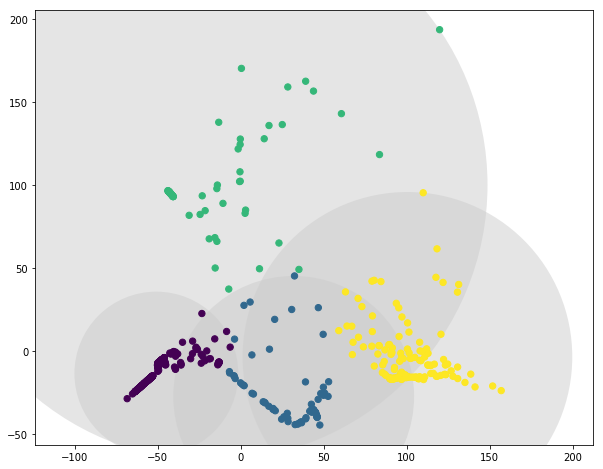

In [170]:
plt.figure(figsize = (10,8))

indices_isomap = kmeans.fit_predict(X_reduced_isomap)
plot_kmeans(kmeans, X_reduced_isomap)

In [178]:
def plot_classification(data, indices, color):
    fig = plt.figure(figsize = (20, 2))
    colors_list = ["violet", "magenta", "teal", "silver", "salmon", "pink"]
    num_color = 0;
    if (len(np.unique(indices)) > 2):
        for i in range(len(indices)):
            if (indices[i] == 0):
                plt.axvline(x = i, color = 'blue')
            elif (indices[i] == 1):
                plt.axvline(x = i, color = 'orange')
            elif (indices[i] == 2):
                plt.axvline(x = i, color = 'green')
            elif (indices[i] == 3 ):
                plt.axvline(x = i, color = 'red')
            else:
                if (num_color == len(colors_list)):
                    num_color = 0
                else:
                    plt.axvline(x = i, color = colors_list[num_color], alpha = 0.01)
                    num_color += num_color
                
    else:
        for i in range(len(indices)):
            if (indices [i] == 0):
                plt.axvline(x = i, color = 'purple', alpha = 0.01)
            elif (indices [i] == 1):
                plt.axvline(x = i, color = 'yellow')
    
    plt.plot(data, color)
    plt.plot(indices)

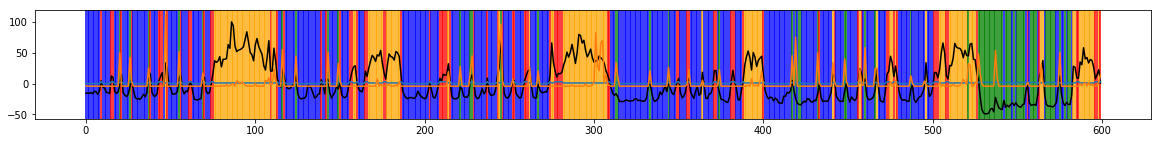

In [179]:
plot_classification(reduce["brain.data"], indices_isomap, "black")
plt.plot(reduce["mov.mean"])

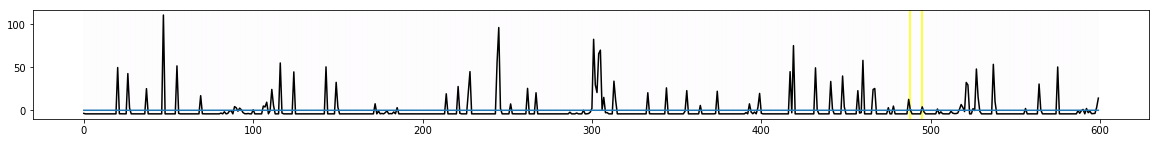

In [173]:
# @param indices the indices of isomap (records where the non twitching actual movements are --> does not take into account 0s)
def find_twitching_regions(indices, data_big):
    twitches = []
    for i in range(len(indices)):
        if indices[i] == 0:
            if reduce["mov.mean"][i] > 0:
                twitches.append(1)
            else:
                twitches.append(0)
        else:
            twitches.append(0)
    return twitches

twitches = find_twitching_regions(indices_isomap, reduce)
plot_classification(reduce["mov.mean"], twitches, "black")

In [ ]:
def make_plot(x, y, mapper, title, color_factor):
    mapper.low_color = 'black'
    mapper.high_color = 'grey'

    TOOLS = 'hover, crosshair, pan, wheel_zoom,\
            zoom_in, zoom_out, box_zoom, undo,\
            redo,reset, tap, save, box_select,\
            poly_select, lasso_select'

    TOOLTIPS = [
    ('Exp', '@index'),
    ('Signal', '@signal'),
    ]

    p = figure(
        tools=TOOLS, tooltips = TOOLTIPS,
        title=title, toolbar_location = 'right'
    )

    p.scatter(
        x=x,
        y=y,
        fill_color={'field': '{0}'.format(color_factor),
                    'transform':mapper},
        line_color=None,
        size = 5,
        source=source)

    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))


    p.add_layout(color_bar, 'left')

    return p

In [ ]:
from bokeh.models import (
    LinearColorMapper, LogColorMapper,
    ColumnDataSource, ColorBar
)
from bokeh.io import output_notebook, show
from bokeh.palettes import brewer, Spectral6, Viridis3, Viridis256, Inferno, Plasma256
from bokeh.plotting import figure, output_file

source = ColumnDataSource(data=dict(
    x = X_reduced_isomap[:, 0],
    y = X_reduced_isomap[:, 1],
    index = data_big.index.values,
    
    angsStDev = np.asarray(non_nan_angs),
    movDuration = np.asarray(data_big['mov.duration']),
    movBtwnRest = np.asarray(data_big['mov.btwnrest']),
    brainData = np.asarray(non_nan_brain),
    classification = np.asarray(data_big['classification'])
))

output_file('Circles.html', title = 'Plotting the isomap graph')

# p1 = make_plot('x', 'y', LinearColorMapper(palette=Plasma256, low=0.0, high=1.0), 'yay', 'angsStDev' )

# show(p1)

In [ ]:
p1 = make_plot(
                'x',
                'y',
                LinearColorMapper(
                   palette=Plasma256,
                   low=source.data['angsStDev'].min(),
                   high=source.data['angsStDev'].max()),
               title = 'angs.stdev',
               color_factor = 'angsStDev'
)
p2 = make_plot(
                'x',
                'y',
                LinearColorMapper(
                    palette=Plasma256,
                    low=source.data['movDuration'].min(),
                    high=source.data['movDuration'].max()),
                title = 'mov.duration',
                color_factor = 'movDuration' )

p3 = make_plot(
                'x',
                'y',
                LinearColorMapper(
                    palette=Plasma256,
                    low=source.data['movBtwnRest'].min(),
                    high=source.data['movBtwnRest'].max()),
                title = 'mov.btwnrest',
                color_factor = 'movBtwnRest' )

p4 = make_plot(
                'x',
                'y',
                LinearColorMapper(
                    palette=Plasma256,
                    low=source.data['brainData'].min(),
                    high=source.data['brainData'].max()),
                title = 'brain.data',
                color_factor = 'brainData' )

p5 = make_plot(
                'x',
                'y',
                LinearColorMapper(
                    palette=Plasma256,
                    low=source.data['classification'].min(),
                    high=source.data['classification'].max()),
                title = 'classification',
                color_factor = 'classification' )

# And so on...  

In [ ]:
from bokeh.layouts import gridplot
grid = (gridplot([p1, p2, p3, p4, p5], 
              ncols=2, plot_width=400, 
              plot_height=300, 
              toolbar_location='left'))

show(grid)

In [ ]:
print(__doc__)

import numpy as np

from sklearn.cluster import OPTICS
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
#centers = [[1, 1], [-1, -1], [1, -1]]

X = X_reduced_isomap
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute OPTICS
opt = OPTICS(eps=2, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(opt.labels_, dtype=bool)
# core_samples_mask[opt.core_sample_indices_] = True
labels = opt.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = 2#len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print('Estimated number of clusters: %d' % n_clusters_)
# print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                            average_method='arithmetic'))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()